**这次主要实现一个多层神经网络**

我们之前已经实现了一个拥有一个隐藏层的神经网络，它还是属于浅层神经网络。
今天我们来实现一个深层网络，你想要多少个隐藏层都可以。

最后，我们要实现下面三个点：
- 用Relu做激活函数提升模型性能
- 搭建一个具有多个隐藏层的深度网络
- 实现一个可以方便调用的神经网络class

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

## 这次我们直接以函数的形式定义好公式，方便后面调用

In [2]:
def sigmoid(Z):
    
    A = 1/(1+np.exp(-Z))
    cache = Z
    
    return A, cache

def relu(Z):
    
    A = np.maximum(0,Z)
    
    assert(A.shape == Z.shape)
    
    cache = Z 
    return A, cache


def relu_backward(dA, cache):
    
    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    
    # When z <= 0, you should set dz to 0 as well. 
    dZ[Z <= 0] = 0
    
    assert (dZ.shape == Z.shape)
    
    return dZ

def sigmoid_backward(dA, cache):

    Z = cache
    
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    assert (dZ.shape == Z.shape)
    
    return dZ

## 同时定义好为了测试每个函数可能会用到的随机参数

In [3]:
def linear_forward_test_case():
    np.random.seed(1)
    """
    X = np.array([[-1.02387576, 1.12397796],
 [-1.62328545, 0.64667545],
 [-1.74314104, -0.59664964]])
    W = np.array([[ 0.74505627, 1.97611078, -1.24412333]])
    b = np.array([[1]])
    """
    A = np.random.randn(3,2)
    W = np.random.randn(1,3)
    b = np.random.randn(1,1)
    
    return A, W, b

def linear_activation_forward_test_case():
    """
    X = np.array([[-1.02387576, 1.12397796],
 [-1.62328545, 0.64667545],
 [-1.74314104, -0.59664964]])
    W = np.array([[ 0.74505627, 1.97611078, -1.24412333]])
    b = 5
    """
    np.random.seed(2)
    A_prev = np.random.randn(3,2)
    W = np.random.randn(1,3)
    b = np.random.randn(1,1)
    return A_prev, W, b

def L_model_forward_test_case():
    """
    X = np.array([[-1.02387576, 1.12397796],
 [-1.62328545, 0.64667545],
 [-1.74314104, -0.59664964]])
    parameters = {'W1': np.array([[ 1.62434536, -0.61175641, -0.52817175],
        [-1.07296862,  0.86540763, -2.3015387 ]]),
 'W2': np.array([[ 1.74481176, -0.7612069 ]]),
 'b1': np.array([[ 0.],
        [ 0.]]),
 'b2': np.array([[ 0.]])}
    """
    np.random.seed(1)
    X = np.random.randn(4,2)
    W1 = np.random.randn(3,4)
    b1 = np.random.randn(3,1)
    W2 = np.random.randn(1,3)
    b2 = np.random.randn(1,1)
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return X, parameters

def compute_cost_test_case():
    Y = np.asarray([[1, 1, 1]])
    aL = np.array([[.8,.9,0.4]])
    
    return Y, aL

def linear_backward_test_case():
    """
    z, linear_cache = (np.array([[-0.8019545 ,  3.85763489]]), (np.array([[-1.02387576,  1.12397796],
       [-1.62328545,  0.64667545],
       [-1.74314104, -0.59664964]]), np.array([[ 0.74505627,  1.97611078, -1.24412333]]), np.array([[1]]))
    """
    np.random.seed(1)
    dZ = np.random.randn(1,2)
    A = np.random.randn(3,2)
    W = np.random.randn(1,3)
    b = np.random.randn(1,1)
    linear_cache = (A, W, b)
    return dZ, linear_cache

def linear_activation_backward_test_case():
    """
    aL, linear_activation_cache = (np.array([[ 3.1980455 ,  7.85763489]]), ((np.array([[-1.02387576,  1.12397796], [-1.62328545,  0.64667545], [-1.74314104, -0.59664964]]), np.array([[ 0.74505627,  1.97611078, -1.24412333]]), 5), np.array([[ 3.1980455 ,  7.85763489]])))
    """
    np.random.seed(2)
    dA = np.random.randn(1,2)
    A = np.random.randn(3,2)
    W = np.random.randn(1,3)
    b = np.random.randn(1,1)
    Z = np.random.randn(1,2)
    linear_cache = (A, W, b)
    activation_cache = Z
    linear_activation_cache = (linear_cache, activation_cache)
    
    return dA, linear_activation_cache

def L_model_backward_test_case():
    """
    X = np.random.rand(3,2)
    Y = np.array([[1, 1]])
    parameters = {'W1': np.array([[ 1.78862847,  0.43650985,  0.09649747]]), 'b1': np.array([[ 0.]])}

    aL, caches = (np.array([[ 0.60298372,  0.87182628]]), [((np.array([[ 0.20445225,  0.87811744],
           [ 0.02738759,  0.67046751],
           [ 0.4173048 ,  0.55868983]]),
    np.array([[ 1.78862847,  0.43650985,  0.09649747]]),
    np.array([[ 0.]])),
   np.array([[ 0.41791293,  1.91720367]]))])
   """
    np.random.seed(3)
    AL = np.random.randn(1, 2)
    Y = np.array([[1, 0]])

    A1 = np.random.randn(4,2)
    W1 = np.random.randn(3,4)
    b1 = np.random.randn(3,1)
    Z1 = np.random.randn(3,2)
    linear_cache_activation_1 = ((A1, W1, b1), Z1)

    A2 = np.random.randn(3,2)
    W2 = np.random.randn(1,3)
    b2 = np.random.randn(1,1)
    Z2 = np.random.randn(1,2)
    linear_cache_activation_2 = ((A2, W2, b2), Z2)

    caches = (linear_cache_activation_1, linear_cache_activation_2)

    return AL, Y, caches

def update_parameters_test_case():
    """
    parameters = {'W1': np.array([[ 1.78862847,  0.43650985,  0.09649747],
        [-1.8634927 , -0.2773882 , -0.35475898],
        [-0.08274148, -0.62700068, -0.04381817],
        [-0.47721803, -1.31386475,  0.88462238]]),
 'W2': np.array([[ 0.88131804,  1.70957306,  0.05003364, -0.40467741],
        [-0.54535995, -1.54647732,  0.98236743, -1.10106763],
        [-1.18504653, -0.2056499 ,  1.48614836,  0.23671627]]),
 'W3': np.array([[-1.02378514, -0.7129932 ,  0.62524497],
        [-0.16051336, -0.76883635, -0.23003072]]),
 'b1': np.array([[ 0.],
        [ 0.],
        [ 0.],
        [ 0.]]),
 'b2': np.array([[ 0.],
        [ 0.],
        [ 0.]]),
 'b3': np.array([[ 0.],
        [ 0.]])}
    grads = {'dW1': np.array([[ 0.63070583,  0.66482653,  0.18308507],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ]]),
 'dW2': np.array([[ 1.62934255,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ]]),
 'dW3': np.array([[-1.40260776,  0.        ,  0.        ]]),
 'da1': np.array([[ 0.70760786,  0.65063504],
        [ 0.17268975,  0.15878569],
        [ 0.03817582,  0.03510211]]),
 'da2': np.array([[ 0.39561478,  0.36376198],
        [ 0.7674101 ,  0.70562233],
        [ 0.0224596 ,  0.02065127],
        [-0.18165561, -0.16702967]]),
 'da3': np.array([[ 0.44888991,  0.41274769],
        [ 0.31261975,  0.28744927],
        [-0.27414557, -0.25207283]]),
 'db1': 0.75937676204411464,
 'db2': 0.86163759922811056,
 'db3': -0.84161956022334572}
    """
    np.random.seed(2)
    W1 = np.random.randn(3,4)
    b1 = np.random.randn(3,1)
    W2 = np.random.randn(1,3)
    b2 = np.random.randn(1,1)
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    np.random.seed(3)
    dW1 = np.random.randn(3,4)
    db1 = np.random.randn(3,1)
    dW2 = np.random.randn(1,3)
    db2 = np.random.randn(1,1)
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}
    
    return parameters, grads


def L_model_forward_test_case_2hidden():
    np.random.seed(6)
    X = np.random.randn(5,4)
    W1 = np.random.randn(4,5)
    b1 = np.random.randn(4,1)
    W2 = np.random.randn(3,4)
    b2 = np.random.randn(3,1)
    W3 = np.random.randn(1,3)
    b3 = np.random.randn(1,1)
  
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return X, parameters

def print_grads(grads):
    print ("dW1 = "+ str(grads["dW1"]))
    print ("db1 = "+ str(grads["db1"]))
    print ("dA1 = "+ str(grads["dA2"])) 
    

##### 不管网络的深度如何，其整体架构都是相似的，之前我们既然能够完成具有一个隐藏层的网络，那么多层的网络实现起来也是很容易的

同样，我们需要构造很多的函数来初始化参数、向前传播、计算损失函数、反向传播求导、最小化损失函数、更新参数……然后，我们将这些函数整合起来就搭建完成了神经网络。

### 接下来我们通过对比的方式，逐步实现两层(一个隐藏层)和多层神经网络(多个隐藏层)的搭建。

# 初始化过程

In [4]:
# 两层神经网络的参数初始化

def initialize_parameters(n_x, n_h, n_y):
    
    np.random.seed(1)
    
    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros(shape=(n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros(shape=(n_y, 1))
    
    assert(W1.shape == (n_h, n_x))
    assert(b1.shape == (n_h, 1))
    assert(W2.shape == (n_y, n_h))
    assert(b2.shape == (n_y, 1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters    

In [5]:
# 测试函数
parameters = initialize_parameters(2,2,1)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[ 0.01624345 -0.00611756]
 [-0.00528172 -0.01072969]]
b1 = [[ 0.]
 [ 0.]]
W2 = [[ 0.00865408 -0.02301539]]
b2 = [[ 0.]]


多层神经网络肯定是要比一两层的复杂的，多层神经网络会有更多的w矩阵和b向量，而且你要很确定每一个维度都要和你定的shape匹配，不然就会报错。不过，不管是多少层的网络，这些东西都是我们一定要注意的。

**围绕下面的结构，你可以很容易的建立一个多层神经网络。**

1. 整个模型的计算流程基本上是:*[LINEAR -> RELU] $ \times$ (L-1) -> LINEAR -> SIGMOID*. I.e.,  $L-1$ 就是这个多层网络的层数，只有经过激活的“层”才能完整的被称为一个层！最终的输出由于是二分类模型，因此使用sigmoid.
2. 我们使用Numpy的np.random.rand(shape) * 0.01初始化权重矩阵,np.zeros(shape)初始化偏差向量。
3. 然后你还记得上节的内容我们是怎么定义网络的？我们的layer_size = [2,4,1],意味着输入是两个；隐藏层有四个节点。每个节点都要有一个w和b；最后的输出只有一个单元。换句话说，W1的shape是(4,2), b1是(4,1), W2是(1,4)， b2是 (1,1)，那么，如果layer = L ,应该怎么做？

In [6]:
# 多层神经网络的参数初始化

def initialize_parameters_deep(layer_dims):
    
    np.random.seed(3)
    parameters = {}
    
    # L是layer_dims的长度，隐藏层数就是L-1
    L = len(layer_dims)

    # 使用循环的方式，将每一层初始化的结果添加到parameters字典里面,用w1,w2....b1,b2来表示
    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l - 1]) * 0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l - 1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

        
    return parameters

In [9]:
parameters = initialize_parameters_deep([5,4,3,2])
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))
print("W3 = " + str(parameters["W3"]))
print("b3 = " + str(parameters["b3"]))

W1 = [[ 0.01788628  0.0043651   0.00096497 -0.01863493 -0.00277388]
 [-0.00354759 -0.00082741 -0.00627001 -0.00043818 -0.00477218]
 [-0.01313865  0.00884622  0.00881318  0.01709573  0.00050034]
 [-0.00404677 -0.0054536  -0.01546477  0.00982367 -0.01101068]]
b1 = [[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]]
W2 = [[-0.01185047 -0.0020565   0.01486148  0.00236716]
 [-0.01023785 -0.00712993  0.00625245 -0.00160513]
 [-0.00768836 -0.00230031  0.00745056  0.01976111]]
b2 = [[ 0.]
 [ 0.]
 [ 0.]]
W3 = [[-0.01244123 -0.00626417 -0.00803766]
 [-0.02419083 -0.00923792 -0.01023876]]
b3 = [[ 0.]
 [ 0.]]


### 现在我们已经定义好了多层神经网络初始化参数的函数，下面就要开始向前传播的过程了

多层网络向前传播主要由以下几个步骤组成:
- 输入 * w + b的线性计算得到Z1
- 使用Relu激活Z1得到结果A1
- 第一次激活后的结果A1 * w + b的线性计算,得到Z2
- 再使用Relu激活Z2得到A2
- 如果有其他层，则重复上述步骤
- 最后一层的结果输出使用sigmoid输出
- 总结起来就是:[LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID (whole model)

我们可以分线性计算向前传播和激活函数向前传播两部分来完成向前传播过程。

In [10]:
# linear_forward

def linear_forward(A, W, b):
    
    Z = np.dot(W, A) + b
    
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    
    return Z, cache

In [11]:
# 测试一下函数
A, W, b = linear_forward_test_case()

Z, linear_cache = linear_forward(A, W, b)
print("Z = " + str(Z))

Z = [[ 3.26295337 -1.23429987]]


In [12]:
# 激活函数向前传播

def linear_activation_forward(A_prev, W, b, activation):

    # 最终结果是Sigmoid函数
    if activation == "sigmoid":

        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)

    
    # 中间层的激活函数都是Relu
    elif activation == "relu":


        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)

    
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache

In [13]:
# 测试一下函数
A_prev, W, b = linear_activation_forward_test_case()

A, linear_activation_cache = linear_activation_forward(A_prev, W, b, activation = "sigmoid")
print("With sigmoid: A = " + str(A))

A, linear_activation_cache = linear_activation_forward(A_prev, W, b, activation = "relu")
print("With ReLU: A = " + str(A))

With sigmoid: A = [[ 0.96890023  0.11013289]]
With ReLU: A = [[ 3.43896131  0.        ]]


**然后我们需要将这两个向前传播的函数应用到具有L个层的神经网络上**

我们通过一个图和一个公式来帮助理解:
<img src="model_architecture_kiank.png" style="width:600px;height:300px;">

$A^{[L]} = \sigma(Z^{[L]}) = \sigma(W^{[L]} A^{[L-1]} + b^{[L]})$. (其实就是我们常说到的 `Yhat`： $\hat{Y}$.)

In [24]:
# L_model_forward

def L_model_forward(X, parameters):

    # 将每一层输出的参数和A[L]都保留在一起
    caches = []
    
    # X(输入)其实就是A(0)
    A = X
    
    # 只有被激活过的值才能被称作完整的一层！因此要向下取整得到神经网络的层数！！
    L = len(parameters) // 2                  
    
    # [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
    for l in range(1, L):
        A_prev = A 

        A, cache = linear_activation_forward(A_prev, 
                                             parameters['W' + str(l)], 
                                             parameters['b' + str(l)], 
                                             activation='relu')
        caches.append(cache)
        

    
    # Sigmoid是最终输出的结果
    # Implement LINEAR -> SIGMOID. Add "cache" to the "caches" list.
    AL, cache = linear_activation_forward(A, 
                                          parameters['W' + str(L)], 
                                          parameters['b' + str(L)], 
                                          activation='sigmoid')
    caches.append(cache)
    
    
    assert(AL.shape == (1, X.shape[1]))
            
    return AL, caches

In [15]:
X, parameters = L_model_forward_test_case_2hidden()
AL, caches = L_model_forward(X, parameters)
print("AL = " + str(AL))
print("Length of caches list = " + str(len(caches)))

AL = [[ 0.03921668  0.70498921  0.19734387  0.04728177]]
Length of caches list = 3


### 接下来就是计算损失函数了，我们同样使用交叉熵作为损失函数

$$-\frac{1}{m} \sum\limits_{i = 1}^{m} (y^{(i)}\log\left(a^{[L] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right)) \tag{7}$$

In [22]:
# compute_cost

def compute_cost(AL, Y):
    
    m = Y.shape[1]

    # Compute loss from aL and y.
    cost = (-1 / m) * np.sum(np.multiply(Y, np.log(AL)) + np.multiply(1 - Y, np.log(1 - AL)))
    
    # np.squeeze 这个函数是从数组的shape中删除单维条目，即把shape中为1的维度去掉,这样可以保证得到cost的shape是可用的
    cost = np.squeeze(cost)      # turns [[17]] into 17
    assert(cost.shape == ())
    
    return cost

In [23]:
# 测试一下函数
Y, AL = compute_cost_test_case()

print("cost = " + str(compute_cost(AL, Y)))

cost = 1.24479479885


### 现在我们需要使用反向传播来计算梯度，进而不断调整参数

反向传播的流程和正向传播差不多，基本上就是下面这个过程，同样包含线性计算部分和激活函数部分：
[LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID (只不过是从结果到输入的过程而已)

下面这张图可以清楚的说明整个流程:
<img src="backprop_kiank.png" style="width:650px;height:250px;">

**紫色部分是向前传播，棕色部分是反向传播**

反向传播要用到的公式我们再列举一下:
$$ dW^{[l]} = \frac{\partial \mathcal{L} }{\partial W^{[l]}} = \frac{1}{m} dZ^{[l]} A^{[l-1] T} \tag{8}$$
$$ db^{[l]} = \frac{\partial \mathcal{L} }{\partial b^{[l]}} = \frac{1}{m} \sum_{i = 1}^{m} dZ^{[l](i)}\tag{9}$$
$$ dA^{[l-1]} = \frac{\partial \mathcal{L} }{\partial A^{[l-1]}} = W^{[l] T} dZ^{[l]} \tag{10}$$


In [25]:
# linear_backward

def linear_backward(dZ, cache):

    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = np.dot(dZ, A_prev.T) / m
    db = np.sum(dZ, axis=1, keepdims=True) / m
    dA_prev = np.dot(W.T, dZ) # dA_prev 即dA[l-1]
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)

    
    return dA_prev, dW, db

In [26]:
# 测试一下函数
dZ, linear_cache = linear_backward_test_case()

dA_prev, dW, db = linear_backward(dZ, linear_cache)
print ("dA_prev = "+ str(dA_prev))
print ("dW = " + str(dW))
print ("db = " + str(db))

dA_prev = [[ 0.51822968 -0.19517421]
 [-0.40506361  0.15255393]
 [ 2.37496825 -0.89445391]]
dW = [[-0.10076895  1.40685096  1.64992505]]
db = [[ 0.50629448]]


In [27]:
# linear_activation_backward

def linear_activation_backward(dA, cache, activation):

    linear_cache, activation_cache = cache
    
    if activation == "relu":
        
        dZ = relu_backward(dA, activation_cache)
        
    elif activation == "sigmoid":
        
        dZ = sigmoid_backward(dA, activation_cache)
    
    dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db

In [28]:
# 测试一下函数

AL, linear_activation_cache = linear_activation_backward_test_case()

dA_prev, dW, db = linear_activation_backward(AL, linear_activation_cache, activation = "sigmoid")
print ("sigmoid:")
print ("dA_prev = "+ str(dA_prev))
print ("dW = " + str(dW))
print ("db = " + str(db) + "\n")

dA_prev, dW, db = linear_activation_backward(AL, linear_activation_cache, activation = "relu")
print ("relu:")
print ("dA_prev = "+ str(dA_prev))
print ("dW = " + str(dW))
print ("db = " + str(db))

sigmoid:
dA_prev = [[ 0.11017994  0.01105339]
 [ 0.09466817  0.00949723]
 [-0.05743092 -0.00576154]]
dW = [[ 0.10266786  0.09778551 -0.01968084]]
db = [[-0.05729622]]

relu:
dA_prev = [[ 0.44090989  0.        ]
 [ 0.37883606  0.        ]
 [-0.2298228   0.        ]]
dW = [[ 0.44513824  0.37371418 -0.10478989]]
db = [[-0.20837892]]


**然后我们需要将这两个反向传播的函数应用到具有L个层的神经网络上**

我们要注意的就是两个点:
1. 我们需要将每一层的结果都存到caches中,因此需要注意不同层的梯度值标记:$$grads["dW" + str(l)] = dW^{[l]}\tag{15} $$
     $l=3$ => $dW^{[l]}$ in `grads["dW3"]`.
2. 还是上面提到的，只有经过激活函数的，才算完整的一层，因此我们循环的是下图圈起来的部分

<img src="mn_backward.png" style="width:450px;height:300px;">

In [31]:
# L_model_backward

def L_model_backward(AL, Y, caches):

    grads = {}
    L = len(caches) # caches里面存储的是每一层计算的结果，因此可以得到层数
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # 让Y的shape和AL的shape一致
    
    # 初始化反向传播的值，需要注意的是这个初始化的值不是随机的，是算出来的
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    # 计算不需要循环部分的梯度
    # Lth layer (SIGMOID -> LINEAR) gradients. Inputs: "AL, Y, caches". Outputs: "grads["dAL"], grads["dWL"], grads["dbL"]
    grads["dA" + str(L)] = dAL
    grads["dA"+str(L-1)], grads["dW"+str(L)], grads["db"+str(L)] = linear_activation_backward(dAL, caches[L-1], activation = "sigmoid")
    
    

    # 需要通过循环计算的每一层的梯度
    for l in reversed(range(L-1)):
        # lth layer: (RELU -> LINEAR) gradients.
        # Inputs: "grads["dA" + str(l + 2)], caches". Outputs: "grads["dA" + str(l + 1)] , grads["dW" + str(l + 1)] , grads["db" + str(l + 1)] 
        dA = grads['dA'+ str(l + 1)]
        dA_prev, dW, db = linear_activation_backward(dA, caches[l], activation = "relu")
        grads["dA" + str(l)] = dA_prev
        grads["dW" + str(l + 1)] = dW
        grads["db" + str(l + 1)] = db

    print(grads)
    return grads

In [30]:
# 测试一下函数
AL, Y_assess, caches = L_model_backward_test_case()
grads = L_model_backward(AL, Y_assess, caches)
print_grads(grads)

{'dW2': array([[-0.39202432, -0.13325855, -0.04601089]]), 'dW1': array([[ 0.41010002,  0.07807203,  0.13798444,  0.10502167],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.05283652,  0.01005865,  0.01777766,  0.0135308 ]]), 'dA0': array([[ 0.        ,  0.52257901],
       [ 0.        , -0.3269206 ],
       [ 0.        , -0.32070404],
       [ 0.        , -0.74079187]]), 'dA1': array([[ 0.12913162, -0.44014127],
       [-0.14175655,  0.48317296],
       [ 0.01663708, -0.05670698]]), 'dA2': array([[-0.5590876 ,  1.77465392]]), 'db1': array([[-0.22007063],
       [ 0.        ],
       [-0.02835349]]), 'db2': array([[ 0.15187861]])}
dW1 = [[ 0.41010002  0.07807203  0.13798444  0.10502167]
 [ 0.          0.          0.          0.        ]
 [ 0.05283652  0.01005865  0.01777766  0.0135308 ]]
db1 = [[-0.22007063]
 [ 0.        ]
 [-0.02835349]]
dA1 = [[-0.5590876   1.77465392]]


**最后一个步骤就是结合学习率更新参数了**

In [32]:
# update_parameters

def update_parameters(parameters, grads, learning_rate):
    
    
    L = len(parameters) // 2 # number of layers in the neural network

    # Update rule for each parameter. Use a for loop.
    for l in range(1, L+1):
        parameters["W" + str(l)] = parameters["W" + str(l)] - learning_rate * grads["dW" + str(l)]
        parameters["b" + str(l)] = parameters["b" + str(l)] - learning_rate * grads["db" + str(l)]
    return parameters

In [33]:
# 测试一下函数
parameters, grads = update_parameters_test_case()
parameters = update_parameters(parameters, grads, 0.1)

print ("W1 = "+ str(parameters["W1"]))
print ("b1 = "+ str(parameters["b1"]))
print ("W2 = "+ str(parameters["W2"]))
print ("b2 = "+ str(parameters["b2"]))

W1 = [[-0.59562069 -0.09991781 -2.14584584  1.82662008]
 [-1.76569676 -0.80627147  0.51115557 -1.18258802]
 [-1.0535704  -0.86128581  0.68284052  2.20374577]]
b1 = [[-0.04659241]
 [-1.28888275]
 [ 0.53405496]]
W2 = [[-0.55569196  0.0354055   1.32964895]]
b2 = [[-0.84610769]]


### 这次我们已经设计了一个多层神经网络的结构，里面每个函数都已经定义好了，下面我们就来找一些数据训练一个模型出来

In [34]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
# 我们先把训练数据读取进来
def load_data():
    train_dataset = h5py.File('/Users/Kum/Desktop/Machine_Learning/project/YIQIXUE_AI/data/week4/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('/Users/Kum/Desktop/Machine_Learning/project/YIQIXUE_AI/data/week4/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

y = 0. It's a non-cat picture.


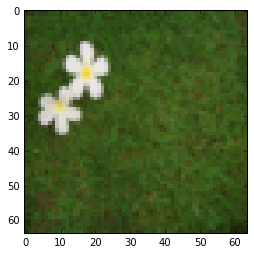

In [36]:
# 然后随便抽一个数据看看图片
# Example of a picture
index = 6
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

In [37]:
# 对我们的训练数据做一个简单的查看
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


**在训练之前，我们要对数据做一些简单的预处理**

1. 我们需要将图片数据(长 X 宽 X 通道数)“压平”，即转化为一个Vector
2. 对每个图片的像素做归一化处理，即缩放到0~1之间

具体如下图所示:
<img src="imvectorkiank.png" style="width:450px;height:300px;">

In [38]:
# 修改图片的shape
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))

train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


In [39]:
### 定义模型的信息 ####
n_x = 12288     # num_px * num_px * 3
n_h = 7
n_y = 1
layers_dims = (n_x, n_h, n_y)

**搭建一个具有两个隐藏层的模型，里面用到的所有函数都是我们上面定义好的**

In [48]:
def two_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    
    np.random.seed(1)
    grads = {}
    costs = []                              # 保留所有的cost 
    m = X.shape[1]                           # 样本数
    (n_x, n_h, n_y) = layers_dims
    
    # 初始化参数
    parameters = initialize_parameters(n_x, n_h, n_y)
    
    # Get W1, b1, W2 and b2 from the dictionary parameters.
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # 循环(梯度下降)

    for i in range(0, num_iterations):

        # 向前传播: LINEAR -> RELU -> LINEAR -> SIGMOID. Inputs: "X, W1, b1". Output: "A1, cache1, A2, cache2".
        A1, cache1 = linear_activation_forward(X, W1, b1, 'relu')
        A2, cache2 = linear_activation_forward(A1, W2, b2, 'sigmoid')
        
        # 计算cost
        cost = compute_cost(A2, Y)
        
        # 初始化反向传播
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        
        # 反向传播. Inputs: "dA2, cache2, cache1". Outputs: "dA1, dW2, db2; also dA0 (not used), dW1, db1".
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, 'sigmoid')
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, 'relu')
        
        # Set grads['dWl'] to dW1, grads['db1'] to db1, grads['dW2'] to dW2, grads['db2'] to db2
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        
        # 用Learning Rate更新参数.
        parameters = update_parameters(parameters, grads, learning_rate)

        # 将更新的结果重写并准备一下一轮的计算
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        
        # Print the cost every 1000 training example
        if print_cost and i % 1000 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if print_cost and i % 1000 == 0:
            costs.append(cost)
       
    # plot the cost

    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Cost after iteration 0: 144.847394753
Cost after iteration 1000: 70.9404841519
Cost after iteration 2000: 15.547674492
Cost after iteration 3000: 5.8714952479
Cost after iteration 4000: 2.8212828684
Cost after iteration 5000: 1.74978623963
Cost after iteration 6000: 1.2332026355
Cost after iteration 7000: 0.93675896776
Cost after iteration 8000: 0.747253079652
Cost after iteration 9000: 0.616967977785
Cost after iteration 10000: 0.522708568007
Cost after iteration 11000: 0.451590269391
Cost after iteration 12000: 0.396272318458
Cost after iteration 13000: 0.352181199424
Cost after iteration 14000: 0.316230621233
Cost after iteration 15000: 0.286494935311
Cost after iteration 16000: 0.261468391397
Cost after iteration 17000: 0.240206107908
Cost after iteration 18000: 0.221910770603
Cost after iteration 19000: 0.206005247425
Cost after iteration 20000: 0.192104535657
Cost after iteration 21000: 0.17981256708
Cost after iteration 22000: 0.168904436083
Cost after iteration 23000: 0.1591660

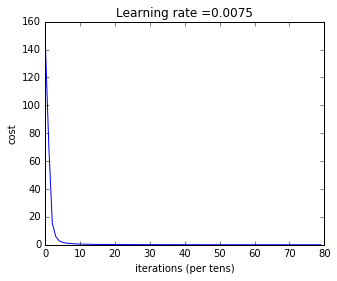

In [49]:
parameters = two_layer_model(train_x, train_y, layers_dims = (n_x, n_h, n_y), num_iterations = 80000, print_cost=True)

### 经历了80000次的迭代，我们可以看到误差值已经很小了，我们来看看这个模型的效果如何。

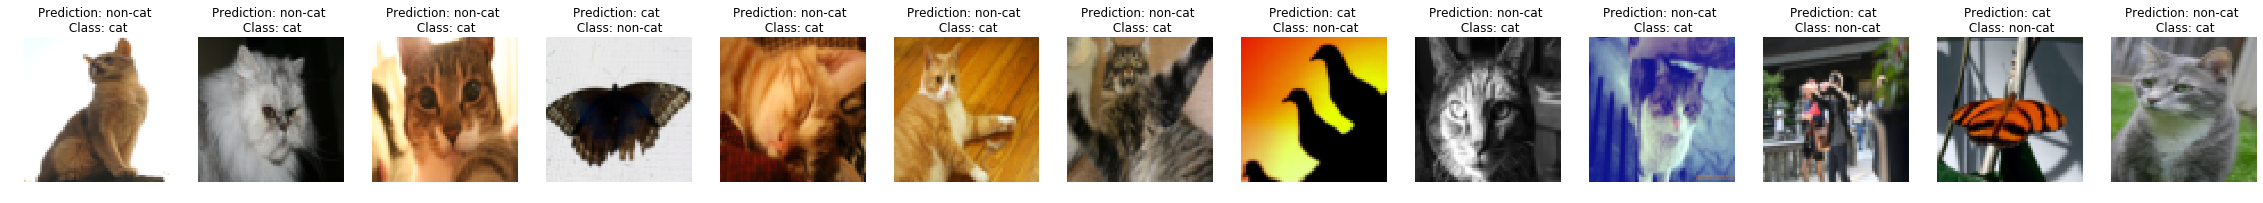

In [62]:
# 看一下错误分类的图片
def print_mislabeled_images(classes, X, y, p):
    """
    Plots images where predictions and truth were different.
    X -- dataset
    y -- true labels
    p -- predictions
    """
    a = p + y
    mislabeled_indices = np.asarray(np.where(a == 1))
    plt.rcParams['figure.figsize'] = (40.0, 40.0) # set default size of plots
    num_images = len(mislabeled_indices[0])
    for i in range(num_images):
        index = mislabeled_indices[1][i]
        
        plt.subplot(2, num_images, i + 1)
        plt.imshow(X[:,index].reshape(64,64,3), interpolation='nearest')
        plt.axis('off')
        plt.title("Prediction: " + classes[int(p[0,index])].decode("utf-8") + " \n Class: " + classes[y[0,index]].decode("utf-8"))

print_mislabeled_images(classes, test_x, test_y, pred_test)

### 用自己的图片测试一下效果

Accuracy: 1
y = 1.0, your L-layer model predicts a "cat" picture.


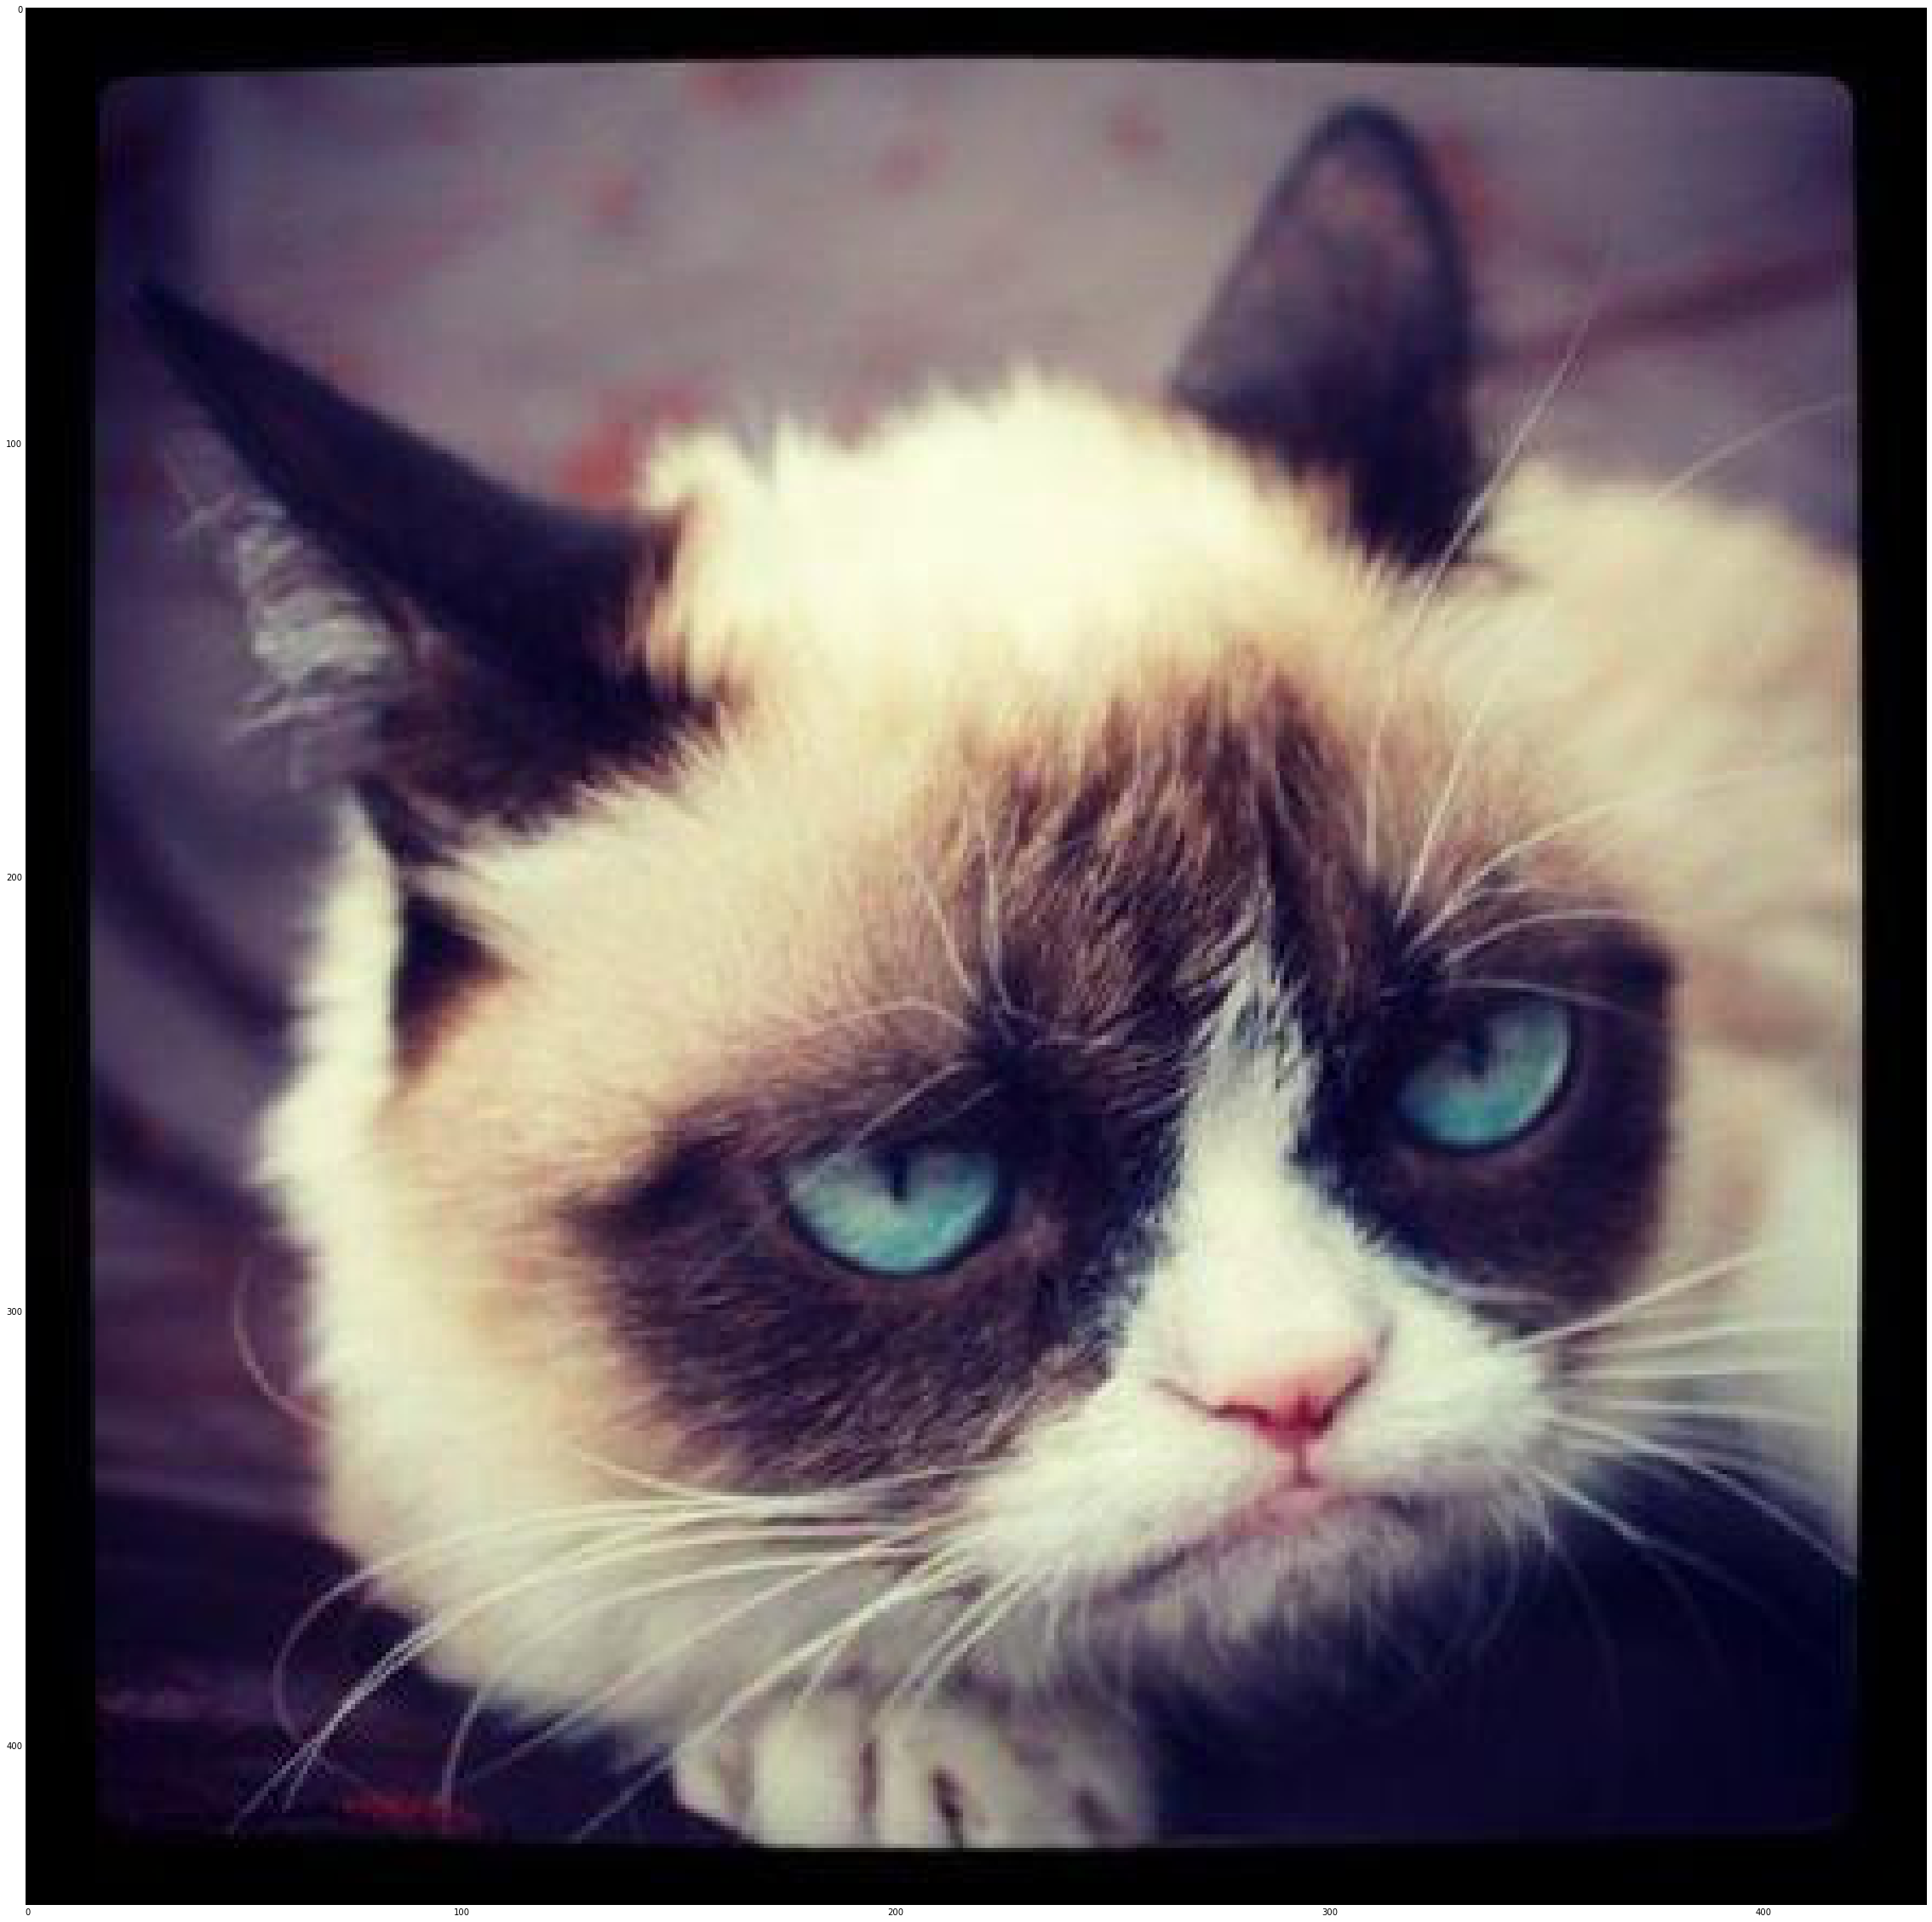

In [64]:
my_image = "/Users/Kum/Desktop/Machine_Learning/project/YIQIXUE_AI/data/week1/angry_cat.jpeg" # change this to the name of your image file 
my_label_y = [1] # the true class of your image (1 -> cat, 0 -> non-cat)


fname = my_image
image = np.array(ndimage.imread(fname, flatten=False))
my_image = scipy.misc.imresize(image, size=(num_px,num_px)).reshape((num_px*num_px*3,1))
my_predicted_image = predict(my_image, my_label_y, parameters)

plt.imshow(image)
print ("y = " + str(np.squeeze(my_predicted_image)) + ", your L-layer model predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")

/Users/Kum/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: overflow encountered in exp
  app.launch_new_instance()


Accuracy: 0
y = 0.0, your L-layer model predicts a "non-cat" picture.


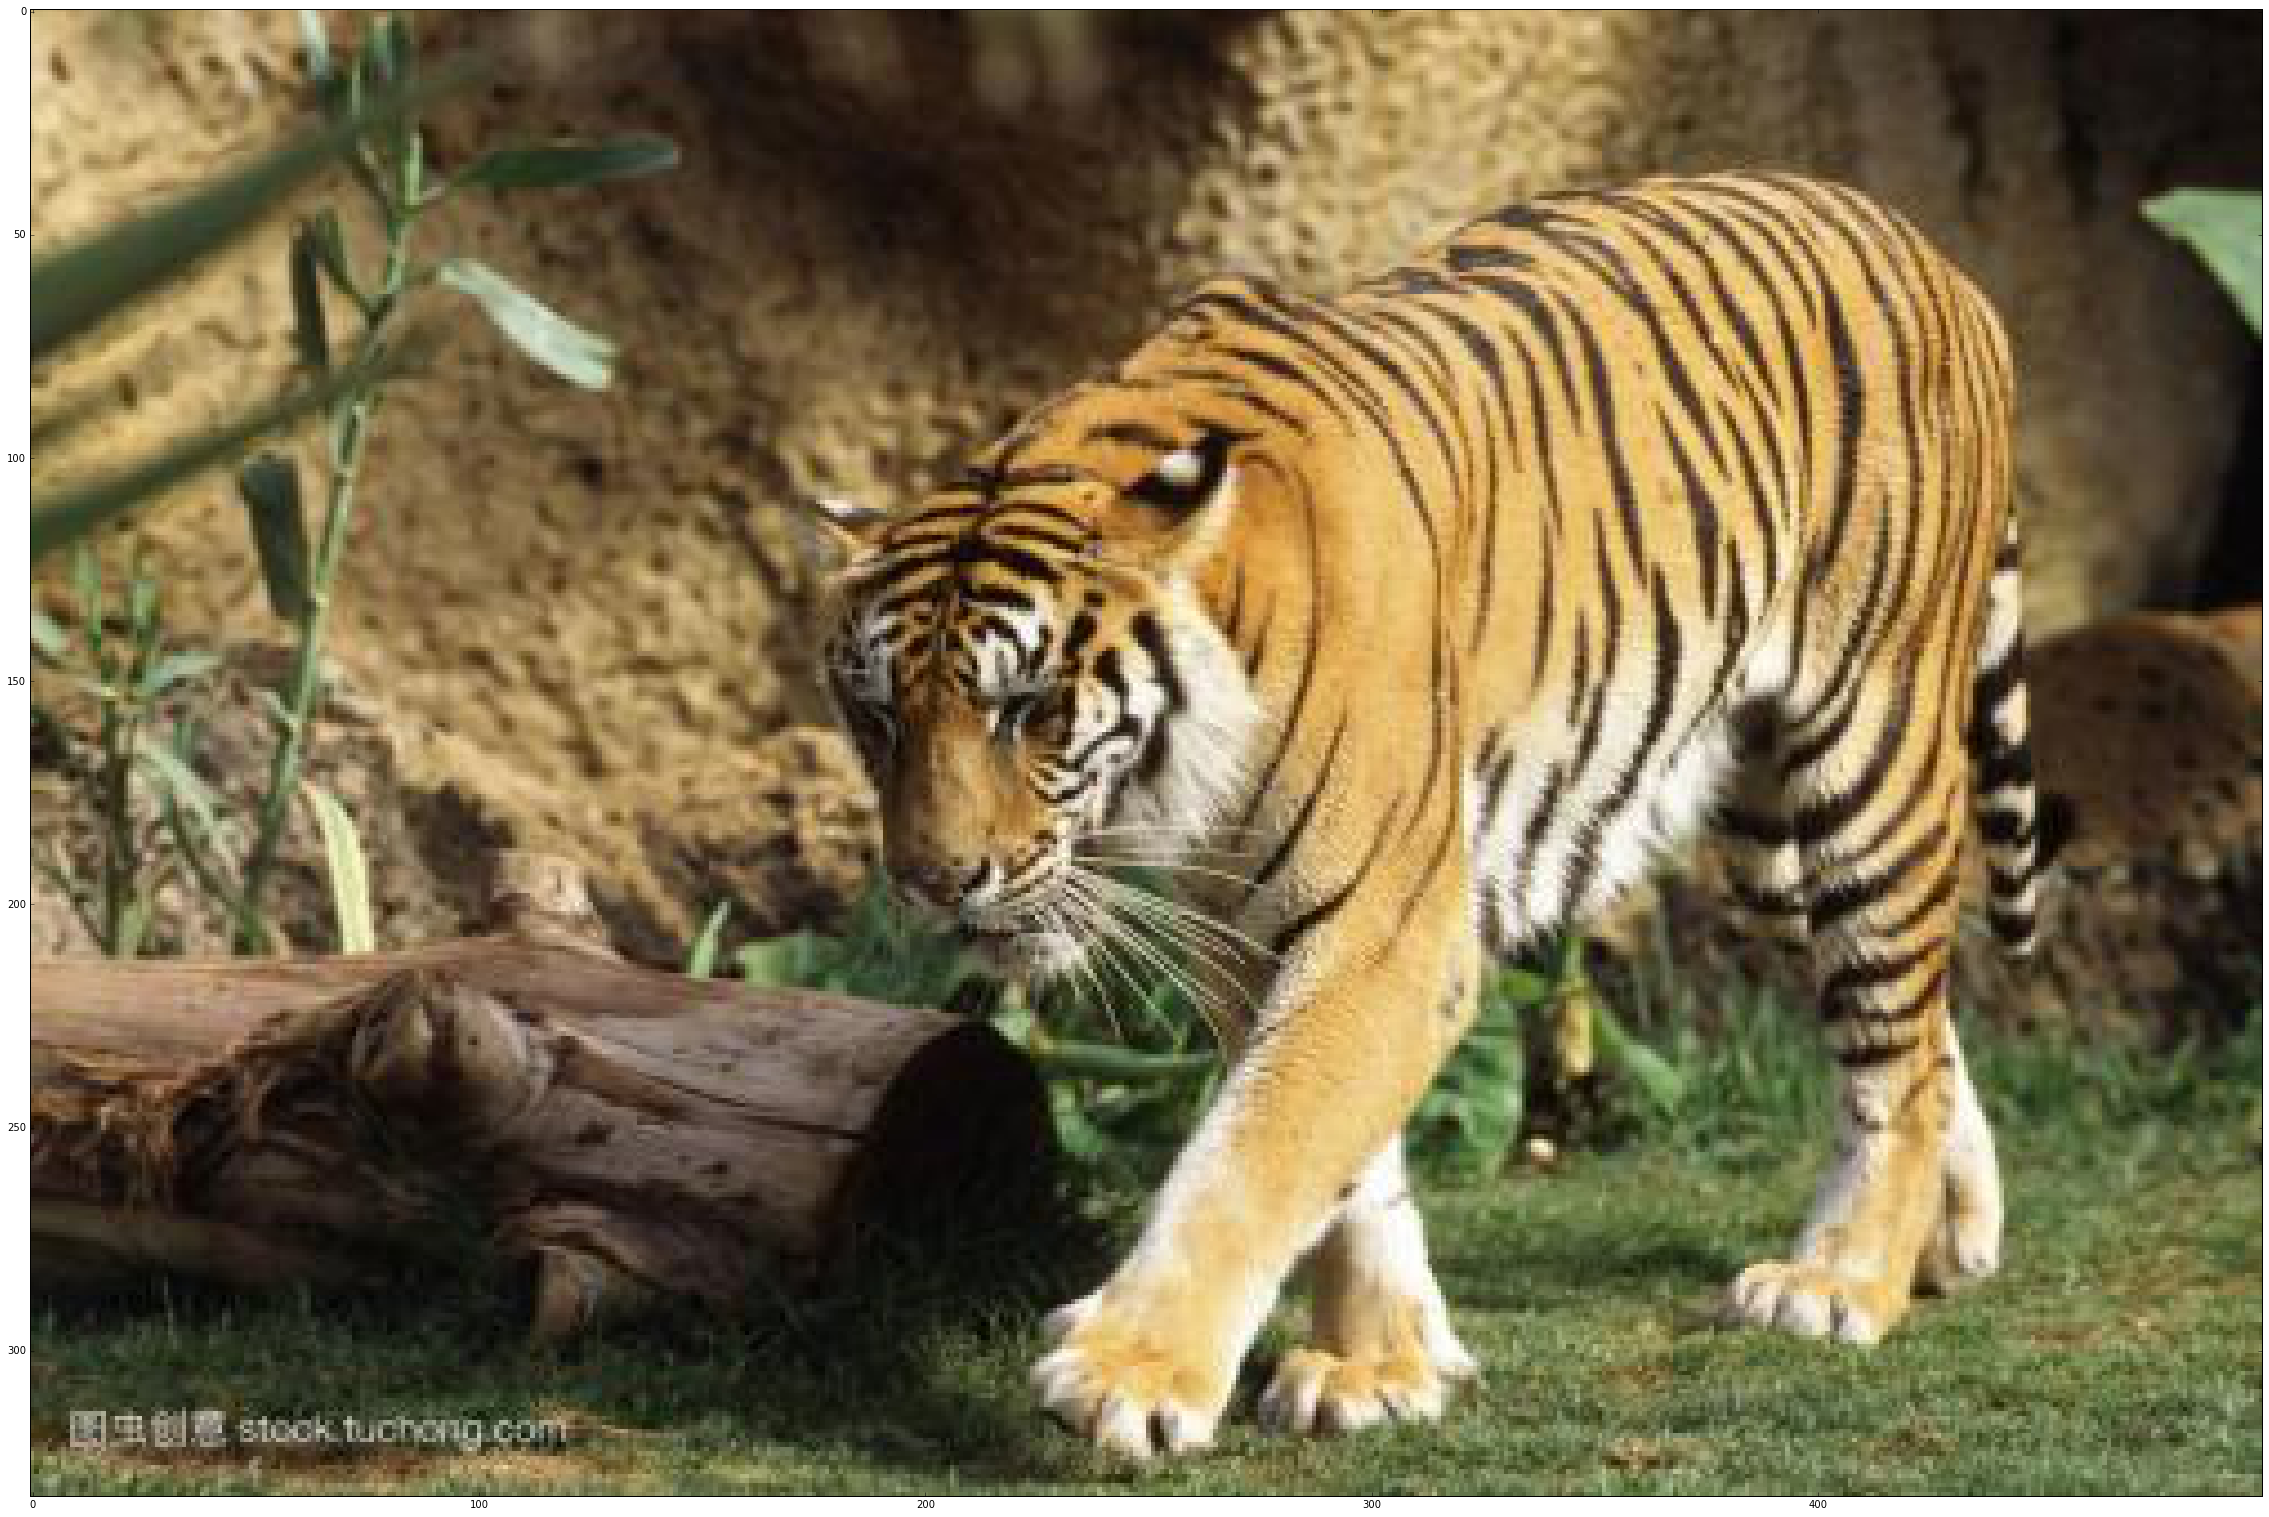

In [65]:
my_image = "/Users/Kum/Desktop/Machine_Learning/project/YIQIXUE_AI/data/week1/tiger.jpg" # change this to the name of your image file 
my_label_y = [1] # the true class of your image (1 -> cat, 0 -> non-cat)


fname = my_image
image = np.array(ndimage.imread(fname, flatten=False))
my_image = scipy.misc.imresize(image, size=(num_px,num_px)).reshape((num_px*num_px*3,1))
my_predicted_image = predict(my_image, my_label_y, parameters)

plt.imshow(image)
print ("y = " + str(np.squeeze(my_predicted_image)) + ", your L-layer model predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")

**我们可以看到，模型还是比较准确的，但是这个仅仅是一个非常简单的深层模型，离真正的落地还有很长一段距离，不过后面我们会学习到更加高大上的模型**